<a href="https://colab.research.google.com/github/dmitryglhf/jupyter-projects/blob/main/without_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score as roc_auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

import torch
import torch.nn as nn
import copy
import torch.optim as optim
import tqdm

### Functions

In [2]:
def householder(a):
    v = a.copy()
    v[0] += np.sign(v[0]) * np.linalg.norm(a)
    v_dot = np.dot(v, v)

    if v_dot == 0:
        H = np.eye(len(a))
    else:
        H = np.eye(len(a)) - 2 * np.outer(v, v) / v_dot
    return H

def get_qr(A):
    n = A.shape[0]
    Q = np.eye(n)
    R = A.copy()

    for j in range(n):
        a = R[j:, j]
        H = householder(a)
        R[j:, j:] = H @ R[j:, j:]
        Q[:, j:] = Q[:, j:] @ H.T

    return Q, R

def eig(A, e=1e-10, max_iter=1000):
    Ak = A.copy()
    eig_vectors = np.eye(A.shape[0])

    for i in range(max_iter):
        Q, R = get_qr(Ak)
        Ak = np.dot(R, Q)
        eig_vectors = np.dot(eig_vectors, Q)

        off_diag_norm = np.sqrt(np.sum(np.tril(Ak, -1) ** 2))
        if off_diag_norm < e:
            break

    eig_values = np.diag(Ak)
    return eig_values, eig_vectors

def svd(A):
    temp_U = A @ A.T
    eig_values_U, U = eig(temp_U)

    idx_U = np.argsort(eig_values_U)[::-1]
    eig_values_U = eig_values_U[idx_U]
    U = U[:, idx_U]

    sigma = np.zeros((A.shape[0], A.shape[1]))
    for i in range(min(A.shape[0], A.shape[1])):
        sigma[i, i] = np.sqrt(eig_values_U[i]) if eig_values_U[i] > 0 else 0

    sigma_inv = np.zeros_like(sigma.T)
    for i in range(min(A.shape[0], A.shape[1])):
        if sigma[i, i] > 0:
            sigma_inv[i, i] = 1 / sigma[i, i]

    V_T = sigma_inv @ U.T @ A
    S = np.diag(sigma)
    return U, S, V_T

def n_components(S):
    exp_var = S[0] / S.sum()
    k = 1
    while exp_var < 0.95:
        exp_var += S[k] / S.sum()
        k += 1
    return k, exp_var

def pca(X):
    U, S, V_T = svd(X)

    # Определение числа главных компонент
    k, exp_var = n_components(S)

    # Обрезаем матрицу до первых k компонент
    U_reduced = U[:, :k]
    sigma_reduced = np.diag(S[:k])

    # Возвращаем проекцию данных на первые k компонент
    X_reduced = U_reduced @ sigma_reduced

    print(f'Число главных компонент: {k}')
    print(f'Доля объяснённой дисперсии: {exp_var}')

    return X_reduced

### Data

In [3]:
data = pd.read_csv('/content/Cancer_Data.csv')

# Преобразование категориальной переменной в бинарную
encoder = LabelEncoder()
data["diagnosis"] = encoder.fit_transform(data["diagnosis"])

# Удаление ненужных столбцов
columns_to_drop = ['id', 'Unnamed: 32']
data.drop(columns_to_drop, axis=1, inplace=True)

# Пример для первых 100 строк данных
data = data.head(100)
X = data.drop('diagnosis', axis=1)
y = data["diagnosis"]

# Стандартизация данных (рекомендуется перед PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Build network

In [4]:
class MyNN(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.hidden = nn.Linear(n, n)
        self.relu = nn.ReLU()
        self.output = nn.Linear(n, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

In [5]:
X_scaled.shape[1]

30

In [6]:
model = MyNN(X_scaled.shape[1])
print(sum([x.reshape(-1).shape[0] for x in model.parameters()]))

961


In [7]:
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 250   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

### Test without PCA

In [8]:
X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [10]:
%%time
acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

Final model accuracy: 100.00%
CPU times: user 4.54 s, sys: 137 ms, total: 4.68 s
Wall time: 10.3 s


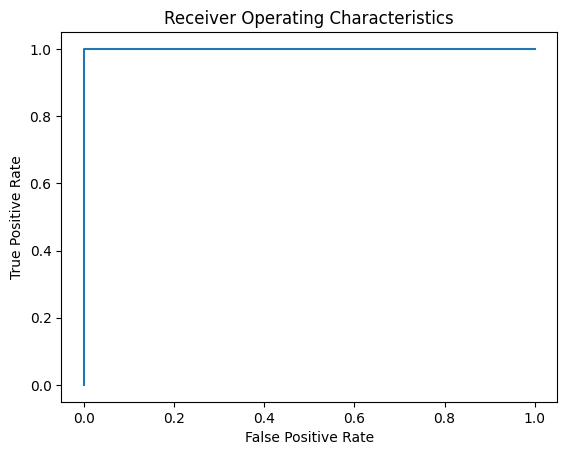

In [11]:
with torch.no_grad():
    # Plot the ROC curve
    y_pred = model(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()